In [1]:
import numpy as np
import os
import random
from os.path import join
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dropout, Flatten, Activation, TimeDistributed, LSTM
from keras.utils import to_categorical
from keras_utils import set_keras_session
from inception_generators import frames_generator_rnn
from plot_utils import plot_history

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
set_keras_session()
dataset = 'UCF11'
nb_classes = int(dataset[3:])

In [9]:
frame_number = 50
width = 320
height = 240
channels = 3

dataset_dir = join('datasets', dataset, ('separate_frames_{}_h_{}_w_{}_inception').format(frame_number, height, width))

sequence_shape = (frame_number, height, width, channels)

In [10]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras import backend as K

def build_model():
    # create the base pre-trained model
       
    rnn = Sequential()
    rnn.add(LSTM(512, input_shape=(frame_number, 2048)))
    rnn.add(Dense(512, activation='relu'))
    rnn.add(Dropout(0.5))
    rnn.add(Dense(nb_classes, activation='softmax'))

    return rnn

In [11]:
batch_size = 1

train_generator = frames_generator_rnn(dataset_dir, 'train', batch_size)
valid_generator = frames_generator_rnn(dataset_dir, 'valid', batch_size)
train_step = next(train_generator)
valid_step = next(valid_generator)

In [12]:
from keras import metrics
from keras import callbacks
from functools import partial

top_3_k_categorical_accuracy = partial(metrics.top_k_categorical_accuracy, k=3)
top_3_k_categorical_accuracy.__name__ = 'top_3'

early_stopper = callbacks.EarlyStopping(patience=2)

model = build_model()
print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 512)               5244928   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 11)                5643      
Total params: 5,513,227
Trainable params: 5,513,227
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
def train_model(**kwargs):
    return model.fit_generator(train_generator,
                    steps_per_epoch=train_step, 
                    validation_data=valid_generator,
                    validation_steps=valid_step,
                    epochs=kwargs.get('epochs', 5))

In [14]:
history = train_model(epochs=10, callbacks=[early_stopper])

Epoch 1/10
1126/1126 [==============================] - 87s 77ms/step - loss: 2.1852 - acc: 0.2460 - top_3: 0.5027 - val_loss: 1.4419 - val_acc: 0.5522 - val_top_3: 0.8550
Epoch 2/10
1126/1126 [==============================] - 88s 78ms/step - loss: 1.2433 - acc: 0.5595 - top_3: 0.8677 - val_loss: 1.0085 - val_acc: 0.6930 - val_top_3: 0.9254
Epoch 3/10
1126/1126 [==============================] - 82s 73ms/step - loss: 0.8226 - acc: 0.7185 - top_3: 0.9440 - val_loss: 0.8932 - val_acc: 0.7036 - val_top_3: 0.9232
Epoch 4/10
1126/1126 [==============================] - 78s 70ms/step - loss: 0.6889 - acc: 0.7540 - top_3: 0.9663 - val_loss: 0.8126 - val_acc: 0.7207 - val_top_3: 0.9147
Epoch 5/10
1126/1126 [==============================] - 80s 71ms/step - loss: 0.5960 - acc: 0.7904 - top_3: 0.9769 - val_loss: 0.8649 - val_acc: 0.7420 - val_top_3: 0.9232
Epoch 6/10
1126/1126 [==============================] - 86s 77ms/step - loss: 0.5034 - acc: 0.8437 - top_3: 0.9742 - val_loss: 0.7862 - val_

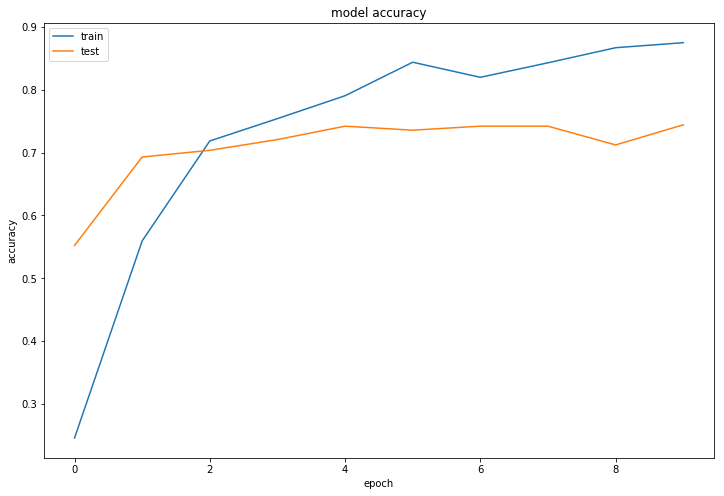

In [15]:
plot_history(history)